In [10]:
import os
import glob
from pathlib import Path
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

import seaborn as sns

def get_algorithm(params_path):
    with open(params_path, "r") as f:
        params = []
        for i, l in enumerate(f.readlines()):
            params.append(l)
    # get params
    ssl = [j.split(" ")[1].strip("\n") for j in params if "ssl_task" in j][0]
    return ssl

def get_best_downstream_loss(tb_dir):
    ea = event_accumulator.EventAccumulator(tb_dir)
    ea.Reload()
    try:  
        loss = ea.Scalars('best_downstream_loss__gen_9')[-1].value
        return loss
    except:
        return None
    

exps =[f"exp6_{i}" for i in range(4)]+ [f"exp8_{i}" for i in range(4, 8)] + \
        [f"exp10_{i}" for i in range(4)] + [f"exp11_{i}" for i in range(4)]


p = Path('/home/noah/ESSL/cc_experiments/')
dirs = [str(p_i) for p_i in list(p.glob('**'))]
# print(glob.glob(f'/home/noah/ESSL/cc_experiments/*/*/', recursive = True))
csv_map = []

for e in exps: 
    e_dirs = [p_i for p_i in dirs if e == p_i.split("/")[-1]]
    csv_map_i = []
    for e_dir in e_dirs:
        model_dirs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/models"))])
        plot_dirs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/plots"))])
        tbs = set([os.path.dirname(p) for p in glob.glob(os.path.join(e_dir, "**/tensorboard"))])
        
        finished_exps = model_dirs.intersection(plot_dirs)
        finished_exps_tbs = finished_exps.intersection(tbs)
        if len(finished_exps) != len(finished_exps_tbs):
            continue
        for f_e in finished_exps:
            csv_map_i.append([e, os.path.basename(f_e), e_dir, f_e])
        
    csv_map+=sorted(csv_map_i, key=lambda x: str(x[1]))
    
columns = ["exp", "seed", "exp_dir", "seed_dir"]
df = pd.DataFrame(csv_map, columns=columns)
display(df[["exp", "seed"]].value_counts())
df = df.drop_duplicates(["exp", "seed"],keep= 'last')

pop_vals_df = []
for exp in df["exp"].unique():
    exp_df = df[df["exp"] == exp]
    pop_vals = []
    for _, row in exp_df.iterrows():
        outcomes_dir = os.path.join(row["seed_dir"], "outcomes.json")
        algo = get_algorithm(os.path.join(row["seed_dir"], "params.txt"))
        try:
            tb = glob.glob(os.path.join(row["seed_dir"], "tensorboard/*/*.tfevents*" ))[0]
            best_loss = get_best_downstream_loss(tb)
        except:
            best_loss = None
        with open(outcomes_dir, "r") as f:
            outcomes = json.load(f)
            pop_vals+=[[exp, algo, row["seed"], i[0], i[1], best_loss] for i in outcomes["pop_vals"]]
    pop_vals_df+=pop_vals
pop_vals_df    
df = pd.DataFrame(pop_vals_df, columns = ["exp", "algo", "seed", "generation", "fitness", "best_loss"])
df


exp      seed
exp6_1   1       5
         0       5
         2       5
exp10_3  1       4
         2       4
                ..
exp11_3  2       1
exp11_1  2       1
         3       1
exp6_3   3       1
exp6_2   8       1
Length: 100, dtype: int64

,exp,algo,seed,generation,fitness,best_loss
0,exp6_0,NNCLR,0,0,83.070000,0.513013
1,exp6_0,NNCLR,0,0,82.070000,0.513013
2,exp6_0,NNCLR,0,0,82.370000,0.513013
3,exp6_0,NNCLR,0,0,83.210000,0.513013
4,exp6_0,NNCLR,0,0,83.230000,0.513013
...,...,...,...,...,...,...
14995,exp11_3,NNCLR,2,9,92.528427,0.302991
14996,exp11_3,NNCLR,2,9,92.685925,0.302991
14997,exp11_3,NNCLR,2,9,92.685925,0.302991
14998,exp11_3,NNCLR,2,9,93.350492,0.302991


In [11]:
def plot_min_max():
    plt.plot(range(len(outcomes['avg'])), outcomes['avg'], 'b-', label=ssl_task)
    plt.plot(range(len(outcomes['max'])), outcomes['max'], 'b-')
    plt.plot(range(len(outcomes['max'])), outcomes['min'], 'b-')
    plt.fill_between(range(len(outcomes['avg'])), outcomes['min'], outcomes['max'], color='b',
                     alpha=0.2)
    plt.xlabel("Generation")
    plt.ylabel("Test Accuracy")
    plt.xticks = (range(len(outcomes['avg'])))
    plt.legend(loc='upper left')
    plt.show()
    plt.clf()

exp10_0


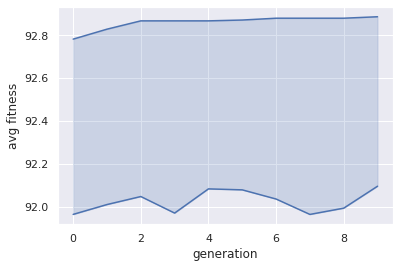

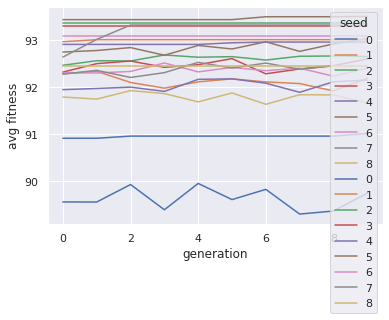

<Figure size 432x288 with 0 Axes>

In [28]:
sns.set_theme()
exps = df.groupby('exp')
for e, df_e in exps:
    exp_results = []
    max_s = []
    for seed, df_e_s in df_e.groupby("seed"):
        for gen, df_e_s_g in df_e_s.groupby("generation"):
            exp_results.append([df_e_s_g["algo"].iloc[0], seed, gen, df_e_s_g["fitness"].mean(), df_e_s_g["fitness"].max()])
            # max_s.append([seed, gen, df_e_s["fitness"].max()])
    res_df = pd.DataFrame(exp_results, columns = ["algorithm", "seed", "generation", "avg fitness", "max fitness"])
    print(e)
    avg_e = res_df.groupby("generation")["avg fitness"].mean().reset_index()
    max_e = res_df.groupby("generation")["max fitness"].mean().reset_index()
    sns.lineplot(data=avg_e, x="generation", y="avg fitness", color='b')
    sns.lineplot(data=max_e, x="generation", y="max fitness", color='b')
    plt.fill_between(avg_e["generation"], avg_e["avg fitness"], max_e["max fitness"], color='b',
                             alpha=0.2)
    plt.show()
    plt.clf()
#     sns.lineplot(
#         data=res_df,
#         x="generation", y="avg fitness", hue="seed",
#     )
#     sns.lineplot(
#         data=res_df,
#         x="generation", y="max fitness", hue="seed",
#     )
    plt.show()
    plt.clf()
    break